In [1]:
import random as rnd
import operator
import os
import time
import copy
import sys

# Data processing
import numpy as np                              # import numpy
import pandas as pd
import json

# Plotting
import matplotlib.pyplot as plt                 # import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as tckr

# Custom packages for simulation
# This works only if notebooks folder is in the "modules" parent folder
sys.path.insert(0, '..') # add modules folder (parent folder) into this notebook's path
import institutions.dm_bargain as dm_bargain
import institutions.dm_travel as dm_travel
import environment.dm_agents as dm_agents
import environment.dm_env as env
import dm_utils as dm
import simulations.dm_sim_period as simulate
import dm_process_results as results
import environment.env_make_agents as make_env
#TODO: Change imported name, propagate

# Agent Types
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

# Using some old functionality of pandas so need this for now - TODO replace the funcitonality
import warnings
warnings.filterwarnings("ignore")

global_num_trials = 10

In [2]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:4} -{price:4}-{s_cos:4}{s_cur:3}    {buyer:10} {seller:10}")

def print_locations(agents):
    for agent in agents:
        print(f"agent {agent.name} is at location {str(agent.get_location())}")

def chk(x, index):
    """
    Checks is x is an integer or list, if a list, returns the integer at the index position
    TODO: Review why this exists?
    """
    typ = type(x)
    assert typ == int or typ == list, "bad type"
    if type(x) == int:
        return x
    elif type(x) == list:
        return x[index]
        
def make_simulation(controls, treat_key, trader_objects, period_verbose=False, debug=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        period_verbose: boolean (optional) - define if the simulation should save and return each 
            period's results
        trader_object: list of ["Trader Type Name", NumTradersOfType] - defines the traders to be used in the simulation
    """
    treat_number = 0
    num_weeks = chk(controls['num_weeks'], treat_number)
    num_periods = chk(controls['num_periods'], treat_number)
    num_rounds = chk(controls['num_rounds'], treat_number)
    grid_size = chk(controls['grid_size'], treat_number)
    num_traders = chk(controls['num_traders'], treat_number)
    num_units = chk(controls['num_units'], treat_number)
    lower_bound = chk(controls['lower_bound'], treat_number)
    upper_bound = chk(controls['upper_bound'], treat_number)
    num_trials = chk(controls['num_trials'], treat_number)

    # New Controls
    m_type = controls['market_type']
    b_type = controls['bidding_type']
    i_types = controls['item_types'] 
    d_rep = controls['default_rep']

    # Setup data tsructure for effs
    effs = []
    for k, treat in enumerate(controls[treat_key]):
        subeffs = []
        for trial in range(num_trials):
            subeffs.append(0)
        effs.append(subeffs)

    ## TODO CONTINUE
    if period_verbose:
        sim_columns = ['num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound', 'treat', 'trial', 'period', 
                               'period_contracts', 'period_locs']
        sim_data = []

    print('Started Simulation')
    for trial in range(num_trials):
        for index, treat in enumerate(controls[treat_key]):
            
            # collect controls
            num_periods = chk(controls['num_periods'], index)
            num_rounds = chk(controls['num_rounds'], index)
            grid_size = chk(controls['grid_size'], index)
            num_traders = chk(controls['num_traders'], index)
            num_units = chk(controls['num_units'], index)
            lower_bound = chk(controls['lower_bound'], index)
            upper_bound = chk(controls['upper_bound'], index)
            
            # make agents
            agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                        grid_size, lower_bound, upper_bound, debug, market_type=m_type, item_types=i_types, default_rep=d_rep)
            agent_maker.make_agents()
            agent_maker.set_locations(grid_size)
            agents = agent_maker.get_agents()

            # set up market
            agent_maker.make_market("test_market")
            market = agent_maker.get_market()
            
            # run sim
            contracts = pd.DataFrame()

            sim_agents = copy.deepcopy(agents)  # reinitialize
            sim1 = simulate.SimPeriod(sim_name, num_rounds, sim_agents, 
                   market, grid_size, debug, plot_on, market_type=m_type, item_types=i_types, bidding_type=b_type)
            
            for period in range(num_periods):
                sim1.run_period()
                contracts = pd.concat([contracts, sim1.get_contracts()])

                # Save the effects of this period on the simuation - movement and contracts
                if period_verbose:

                    # Save starting positions for the simulation at period = -1
                    if period == 0:
                        init_locs = copy.deepcopy(sim1.get_initial_grid())
                        init_data = [num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, treat, trial, -1, 
                                       [], init_locs]
                        sim_data.append(init_data)
                    
                    period_contracts = copy.deepcopy(sim1.get_contracts())
                    period_locs = copy.deepcopy(sim1.get_grid())
                    period_data = [num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, treat, trial, period, 
                                   period_contracts, period_locs]
                    sim_data.append(period_data)
            
            # process results
            pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug, market_type=m_type, item_types=i_types)
            pr1.get_results()
            effs[index][trial] = pr1.get_efficiency()
    print('Finished Simulation')

    if period_verbose:
        df_verbose = pd.DataFrame(data=sim_data, columns=sim_columns)
        return effs, df_verbose, sim1
    
    return effs



In [3]:
# Allows multiple weeks (prev above does not - later weeks one does not follow the same format or allow for multiple trials)
# Only returns dataframes
def make_simulation_wide(controls, trader_objects, debug=False, re_contracts_df=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        controls: dictionary of controls for the simulation
        trader_object: list of ["Trader Type Name", NumTradersOfType] - defines the traders to be used in the simulation
        debug: boolean (optional): should the function print deep debug information
        Note: Dropped the treat_key idea - this should be done on the outside and the function should be called with the controls as a set thing
    """
    treat_number = 0
    num_trials = chk(controls['num_trials'], treat_number) # For monte carlo
    num_weeks = chk(controls['num_weeks'], treat_number) # Contain periods
    num_periods = chk(controls['num_periods'], treat_number) # Number of movement periods
    num_rounds = chk(controls['num_rounds'], treat_number) # number of trading rounds after movement
    grid_size = chk(controls['grid_size'], treat_number) # size of the grid nXn
    num_traders = chk(controls['num_traders'], treat_number) # number of traders - checks against the trader objects 
    num_units = chk(controls['num_units'], treat_number) # number of units each (selling) trader has or buying trader wants (? not sure abou this second half)
    lower_bound = chk(controls['lower_bound'], treat_number) # Minimum valuation of units
    upper_bound = chk(controls['upper_bound'], treat_number) # Maximum valuation of units

    # New Controls
    m_type = controls['market_type']
    b_type = controls['bidding_type']
    i_types = controls['item_types'] 
    d_rep = controls['default_rep']

    sim_columns = ['num_trials', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound', 
                    'trial', 'week', 'period', 'efficiency', 'type_effs', 'period_contracts', 'period_locs', 'market_type', 'bidding_type', 'default_rep']

    
    
    sim_data = []
    
    print('Started Simulation')
    for trial in range(num_trials):

        # make agents
        agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, grid_size, lower_bound, upper_bound, debug, market_type=m_type, item_types=i_types, 
                                          default_rep=d_refp)
        agent_maker.make_agents()
        agent_maker.set_locations(grid_size)
        agents = agent_maker.get_agents()

        # set up market
        agent_maker.make_market("test_market")
        market = agent_maker.get_market()
        
        # run sim
        contracts = pd.DataFrame()
        
        for week in range(num_weeks):
            for agent in agents:
                agent.start(None)
            sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
                   market, grid_size, debug, plot_on, week=week, market_type=m_type, item_types=i_types, bidding_type=b_type)
            for period in range(num_periods):
                sim1.run_period()
                contracts = pd.concat([contracts, sim1.get_contracts().copy()])

                # Save starting positions for the simulation at week and period = -1
                if week==0 and period == 0:
                    init_locs = copy.deepcopy(sim1.get_initial_grid())
                    init_data = [num_trials, num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, 
                                 trial, -1, -1, None, [], [], init_locs, market_type, bidding_type, default_rep]
                    sim_data.append(init_data)

                # process results
                pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
                pr1.get_results() 
                efficiency = pr1.get_efficiency()

                type_eff = pr1.get_type_surplus()
                
                period_contracts = copy.deepcopy(sim1.get_contracts())
                period_locs = copy.deepcopy(sim1.get_grid())
                
                period_data = [num_trials, num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, 
                               trial, week, period, efficiency, type_eff, period_contracts, period_locs, market_type, bidding_type, default_rep]
                sim_data.append(period_data)

    print('Finished Simulation')

    df_verbose = pd.DataFrame(data=sim_data, columns=sim_columns)
    if re_contracts_df:
        return df_verbose, sim1, contracts
    return df_verbose, sim1

In [4]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation_1(controls_1, trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """

    sim_name="Test_SIM"
    plot_on = False
    
    num_weeks = controls_1['num_weeks']
    num_periods = controls_1['num_periods']
    num_rounds = controls_1['num_rounds']
    grid_size = controls_1['grid_size']
    num_traders = controls_1['num_traders']
    num_units = controls_1['num_units']
    lower_bound = controls_1['lower_bound']
    upper_bound = controls_1['upper_bound']

    m_type = controls_1['market_type']
    b_type = controls_1['bidding_type']
    i_types = controls_1['item_types'] 
    d_rep = controls_1['default_rep']

    debug = controls_1['debug']    
    effs = []
    locs = []
    
    # make agents
    agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug, market_type=m_type, item_types=i_types, default_rep=d_rep)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        
        week_contracts = pd.DataFrame()
        for agent in agents:
            agent.start(None)
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on, week=week, market_type=m_type, item_types=i_types, bidding_type=b_type)
        for period in range(num_periods):
            sim1.run_period()
            per_contracts = sim1.get_contracts().copy()
            week_contracts = pd.concat([week_contracts, per_contracts])
        
        locs.append(make_locs(agents))
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, week_contracts, debug, market_type=m_type, item_types=i_types)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)

        #print(week_contracts)
        #print("EFF", eff)
    
    return effs, locs

In [5]:
"""
ZID = dm_agents.ZID     # name of agent class that moves randomly and accepts random offers
trader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same

controls_1 = {
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "ABSTRACT",
    'default_rep': 100,
    'item_types': ['X', 'Y']
}

data_table_6, locs = make_simulation_1(controls_1, trader_objects)

for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)
"""

'\nZID = dm_agents.ZID     # name of agent class that moves randomly and accepts random offers\ntrader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same\n\ncontrols_1 = {\n    \'num_weeks\': 100,\n    \'num_periods\': 7,\n    \'num_rounds\': 5,\n    \'grid_size\': 15,\n    \'num_traders\': 20,\n    \'num_units\': 8,\n    \'lower_bound\': 200,\n    \'upper_bound\': 600,\n    \'debug\': False,\n    \'market_type\': "TWO_TYPE",\n    \'bidding_type\': "ABSTRACT",\n    \'default_rep\': 100,\n    \'item_types\': [\'X\', \'Y\']\n}\n\ndata_table_6, locs = make_simulation_1(controls_1, trader_objects)\n\nfor loc in locs:\n    loc_d = {}\n    for g_loc in loc:\n        if g_loc in loc_d.keys():\n            loc_d[g_loc] += 1\n        else:\n            loc_d[g_loc] = 1\n    #print(len(loc_d), loc_d)\n'

In [6]:
"""ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_7, locs = make_simulation_1(controls_1, trader_objects)"""

'ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point\ntrader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same\n\ndata_table_7, locs = make_simulation_1(controls_1, trader_objects)'

In [7]:
"""fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dashed', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 50)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')"""

"fig, ax = plt.subplots(figsize=(10, 8))  \nax.plot(data_table_7, label = 'ZIDA', linestyle = 'dashed', color='blue', lw =3)\nax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)\n\nax.set_xlabel('week', size = 'x-large') \nax.set_xbound(0, 50)\nax.set_ybound(0, 100)\nax.grid(1)\nax.set_ylabel('efficiency', size = 'x-large') \nax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')\nax.legend(fontsize='x-large')"

In [8]:
def calc_concentration(locs, num_agents, grid_size):
    num_occupied = 0
    occupying = []

    occupied_locs = {}
    for x in range(grid_size):
        for y in range(grid_size):
            for loc in locs:
                if loc == (x, y):
                    if loc in occupied_locs:
                        occupied_locs[loc] += 1
                    else: 
                        occupied_locs[loc] = 1
    num_occupied = len(occupied_locs)
    occupying = np.array(list(occupied_locs.values()))
    shares = occupying/num_agents
    hersh = np.sum(np.square(shares))

    return hersh

In [20]:
def make_simulation_1_cur(controls_1, trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """
    
    num_weeks = controls_1['num_weeks']
    num_periods = controls_1['num_periods']
    num_rounds = controls_1['num_rounds']
    grid_size = controls_1['grid_size']
    num_traders = controls_1['num_traders']
    num_units = controls_1['num_units']
    lower_bound = controls_1['lower_bound']
    upper_bound = controls_1['upper_bound']

    m_type = controls_1['market_type']
    b_type = controls_1['bidding_type']
    i_types = controls_1['item_types'] 
    d_rep = controls_1['default_rep']
    cur_local = controls_1['cur_local']
    gamma = controls_1['gamma']
    debug = controls_1['debug']
    sim_name = controls_1['sim_name']
    plot_on = controls_1['plot_on']

    effs = []
    locs = []
    delinqs = []
    concentrations = []
    
    # make agents
    agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug, market_type=m_type, item_types=i_types, default_rep=d_rep, cur_local=cur_local, gamma=gamma)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        week_contracts = pd.DataFrame()
        delinquents = 0
        w_concent = []
        desired_money = 0
        for agent in agents:
            agent.start(None)
            if b_type == "MONETARY":
                desired_money += agent.request_money("M")
        if b_type == "MONETARY":
            money_issue = desired_money/len(agents)
            for agent in agents:
                arep = agent.get_rep()
                des_money = arep/100*money_issue
                agent.set_money("M", des_money)
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on, week=week, market_type=m_type, item_types=i_types, bidding_type=b_type, cur_local=cur_local)
        for period in range(num_periods):
            sim1.run_period()
            week_contracts = pd.concat([week_contracts, sim1.get_contracts()])
            p_locs = make_locs(agents)
            w_concent.append(calc_concentration(p_locs, len(agents), grid_size))

        if b_type == "MONETARY":
            for agent in agents:
                repaid_in_full = agent.repay_loan()
                if not repaid_in_full:
                    delinquents += 1

        avg_concent = sum(w_concent)/len(w_concent)
        
        concentrations.append(avg_concent)
        locs.append(make_locs(agents))
        delinqs.append(delinquents)
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, week_contracts, debug, market_type=m_type, item_types=i_types)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
    
    return effs, locs, delinqs, concentrations

In [15]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': False,
    'gamma': 1,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_7_cur, locs_cur, delin_cur, concent_cur = make_simulation_1_cur(controls_1, trader_objects)

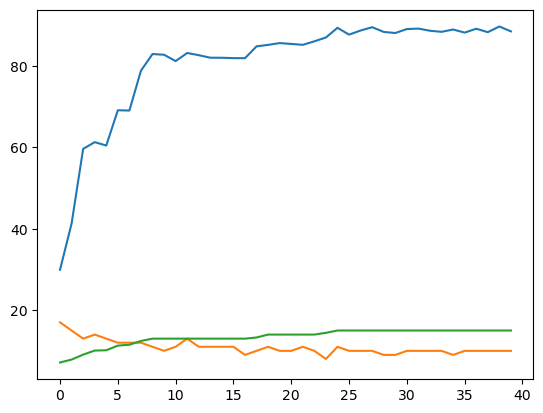

In [16]:
plt.plot(data_table_7_cur)
plt.plot(delin_cur)
plt.plot(np.array(concent_cur)*100)

In [21]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "ABSTRACT",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': False,
    'gamma': 1,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_7_ncr, locs_ncr, delin_ncr, concent_ncr = make_simulation_1_cur(controls_1, trader_objects)

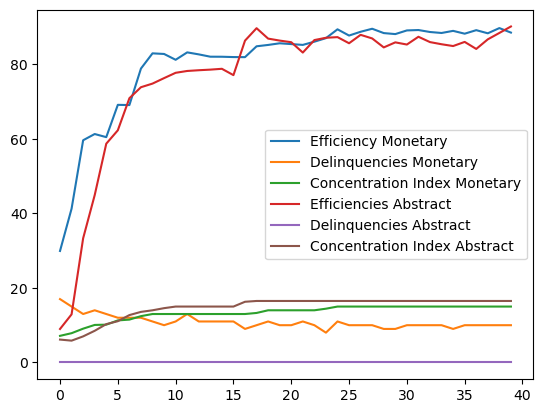

In [22]:
plt.plot(data_table_7_cur, label="Efficiency Monetary")
plt.plot(delin_cur, label="Delinquencies Monetary")
plt.plot(np.array(concent_cur)*100, label="Concentration Index Monetary")

plt.plot(data_table_7_ncr, label="Efficiencies Abstract")
plt.plot(delin_ncr, label="Delinquencies Abstract")
plt.plot(np.array(concent_ncr)*100, label="Concentration Index Abstract")

plt.legend()

In [23]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': True,
    'gamma': 2,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_9_cur, locs_cur_2, delin_cur_2, concent_cur_2 = make_simulation_1_cur(controls_1, trader_objects)

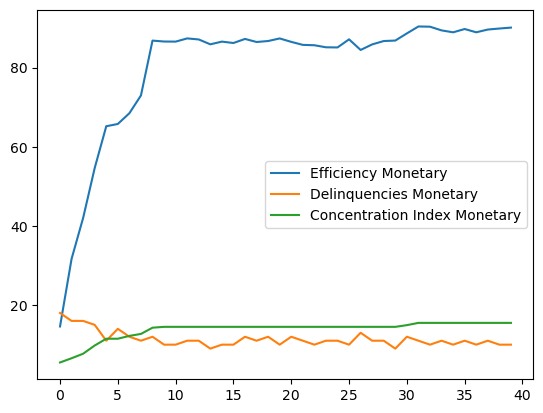

In [25]:
plt.plot(data_table_9_cur, label="Efficiency Monetary")
plt.plot(delin_cur_2, label="Delinquencies Monetary")
plt.plot(np.array(concent_cur_2)*100, label="Concentration Index Monetary")
plt.legend()

In [26]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': True,
    'gamma': 5,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_5_cur, _, delin_cur_5, concent_cur_5 = make_simulation_1_cur(controls_1, trader_objects)

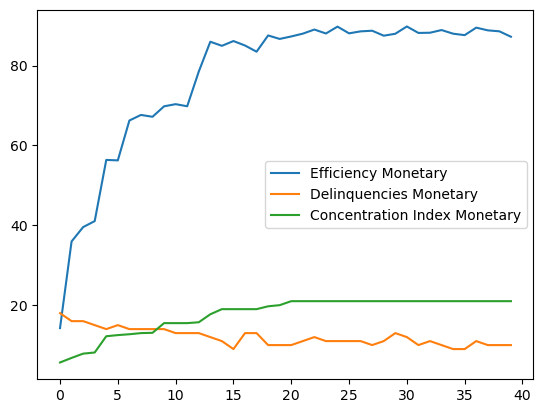

In [27]:
plt.plot(data_table_5_cur, label="Efficiency Monetary")
plt.plot(delin_cur_5, label="Delinquencies Monetary")
plt.plot(np.array(concent_cur_5)*100, label="Concentration Index Monetary")
plt.legend()

In [28]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': True,
    'gamma': 10,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_10_cur, _, delin_cur_10, concent_cur_10 = make_simulation_1_cur(controls_1, trader_objects)

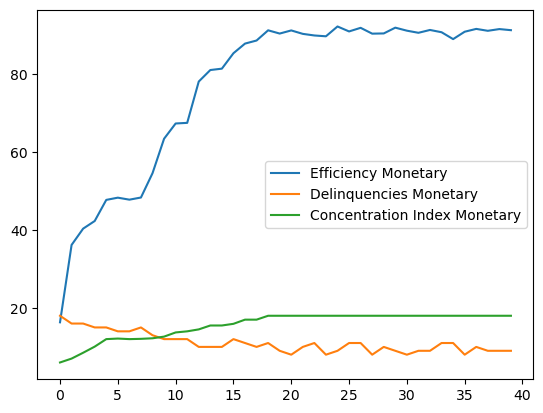

In [29]:
plt.plot(data_table_10_cur, label="Efficiency Monetary")
plt.plot(delin_cur_10, label="Delinquencies Monetary")
plt.plot(np.array(concent_cur_10)*100, label="Concentration Index Monetary")
plt.legend()

In [30]:
controls_1 = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': True,
    'gamma': 20,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_20_cur, _, delin_cur_20, concent_cur_20 = make_simulation_1_cur(controls_1, trader_objects)

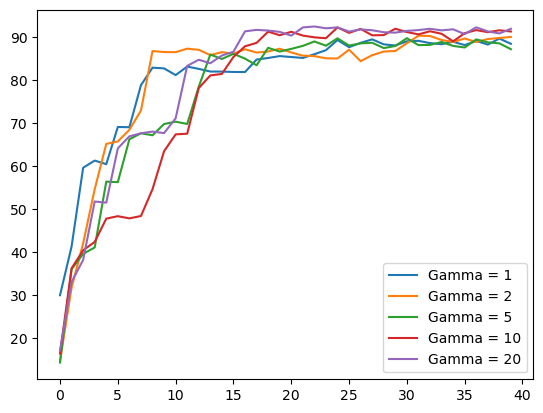

In [33]:
plt.plot(data_table_7_cur, label="Gamma = 1")
plt.plot(data_table_9_cur, label="Gamma = 2")
plt.plot(data_table_5_cur, label="Gamma = 5")
plt.plot(data_table_10_cur, label="Gamma = 10")
plt.plot(data_table_20_cur, label="Gamma = 20")
plt.legend()

In [35]:
controls_b = {
    'num_weeks': 40,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': False,
    'gamma': 1,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
change_out = 'grid_size'
forvals = [1, 3, 5, 7, 10, 13, 15]
labs = []
res = []
cons = []
for i in forvals:
    controls_b[change_out] = i
    labs.append(f"Grid Size = {i}")
    _, _, ult, concent = make_simulation_1_cur(controls_b, trader_objects)
    res.append(ult)
    cons.append(concent)

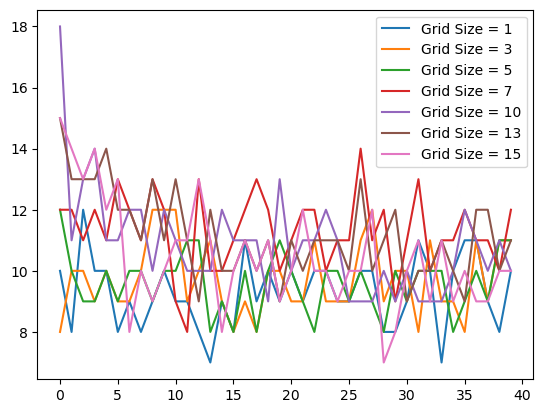

In [37]:
for i in range(len(forvals)):
    plt.plot(res[i], label=labs[i])
plt.legend()

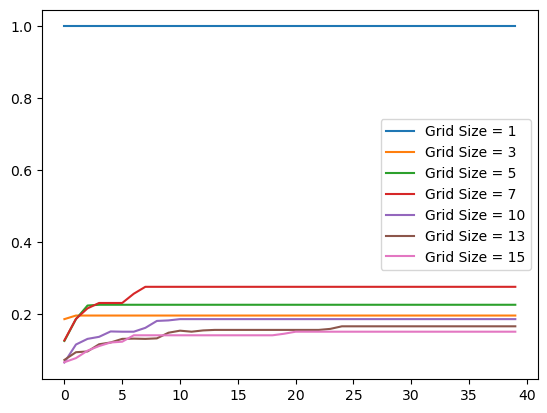

In [38]:
for i in range(len(forvals)):
    plt.plot(cons[i], label=labs[i])
plt.legend()

In [14]:
raise ValueError
# Run Many trials 
controls_1 = {
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "MONETARY",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': False,
    'gamma': 1,
    'debug': False,
    'sim_name': 'Two_Way_Cur_Glob',
    'plot_on': False
}
trial_name = "Global Currency"
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

trial_cols = ['trial_id', 'efficiencies', 'delins', 'concent']
global_trial = pd.DataFrame(columns=trial_cols)
for trial in range(10):
    tr_data, _, tr_delins, tr_concent = make_simulation_1_cur(controls_1, trader_objects)
    trial_data = (trial, tr_data, tr_delins, tr_concent)
    global_trial.loc[trial] = trial_data

ValueError: 

In [ ]:
"""controls_1 = {
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600,
    'debug': False,
    'market_type': "TWO_TYPE",
    'bidding_type': "ABSTRAC",
    'default_rep': 100,
    'item_types': ['X', 'Y'],
    'cur_local': False,
    'gamma': 1
}
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_7, locs = make_simulation_1(controls_1, trader_objects)"""